# Newson and Krumm 2009

In [1]:
import numpy as np
from scipy import stats
import matplotlib.pyplot as plt
import sqlite3
from tabulate import tabulate
import smopy
import folium

## Database

In [2]:
fn = "/Users/wannes/Projects/Research/2016-MapMatching/repo_mapmatching/tests/rsrc/newson_krumm_2009/road_network.sqlite"
conn = sqlite3.connect(fn)
c = conn.cursor()

In [3]:
def query(q, v=None, headers=()):
    if v is None:
        c.execute(q)
    else:
        c.execute(q, v)
    rows = c.fetchall()
    if len(headers) == 0 and c.description is not None:
        headers = [row[0] for row in c.description]
    print(tabulate(rows, headers=headers))

In [23]:
query("SELECT * FROM edges WHERE id1=884147405164")

                 id          path    pathnum           id1           id2    speed    type
-------------------  ------------  ---------  ------------  ------------  -------  ------
8057285611342518121                           884147405164  884147400698                1
8057285635047650571                           884147405164  884147405164                1
8902228981580461271  884147407418          1  884147405164        141488  11.1111       0


In [4]:
query("SELECT * FROM edges WHERE path=884147407419")

                 id          path    pathnum           id1           id2    speed    type
-------------------  ------------  ---------  ------------  ------------  -------  ------
3866146660630628456  884147407419          2        141493        141494  11.1111       0
4697398260954794281  884147407419          3        141494  884147405164  11.1111       0
8902229780325862621  884147407419          1  884147405165        141493  11.1111       0


In [5]:
query("SELECT * FROM edges WHERE path=884147400648 OR path=884147400756 ORDER BY path")

                 id          path    pathnum           id1           id2    speed    type
-------------------  ------------  ---------  ------------  ------------  -------  ------
3850305214222701756  884147400648          2        136155        136156  11.1111       0
4695822844914209756  884147400648          3        136156  884147400697  11.1111       0
8929506531003134596  884147400648          1  884147400698        136155  11.1111       0
8053989437215104846  884147400756          1  884147400798  884147400797  26.3889       0


In [8]:
paths = [884147407419, 884147400648, 884147400756]

In [14]:
path_nodes = {path: c.execute(f"SELECT id1, id2 FROM edges WHERE path={path} ORDER BY pathnum").fetchall()
              for path in paths}

In [15]:
print(path_nodes)

{884147407419: [(884147405165, 141493), (141493, 141494), (141494, 884147405164)], 884147400648: [(884147400698, 136155), (136155, 136156), (136156, 884147400697)], 884147400756: [(884147400798, 884147400797)]}


In [17]:
path_locs = {}
for path, nodepairs in path_nodes.items():
    nodes = [node for nodes in nodepairs for node in nodes]
    path_locs[path] = [c.execute(f"SELECT y, x FROM nodes WHERE id={node}").fetchone() for node in nodes]

In [18]:
path_locs

{884147407419: [(47.6427000761032, -122.322528362274),
  (47.6425793766975, -122.322289645672),
  (47.6425793766975, -122.322289645672),
  (47.6424908638, -122.322080433369),
  (47.6424908638, -122.322080433369),
  (47.6424103975296, -122.321809530258)],
 884147400648: [(47.6424103975296, -122.321809530258),
  (47.6423299312592, -122.322139441967),
  (47.6423299312592, -122.322139441967),
  (47.6422494649887, -122.322340607643),
  (47.6422494649887, -122.322340607643),
  (47.6421502232552, -122.32253909111)],
 884147400756: [(47.6421502232552, -122.32253909111),
  (47.6427000761032, -122.322528362274)]}

In [22]:
location = path_locs[884147407419][0]
print(location)
m = folium.Map(location=location, zoom_start=17)
m.add_child(folium.PolyLine(locations=path_locs[884147407419], weight=5, color="red"))
m.add_child(folium.PolyLine(locations=path_locs[884147400648], weight=5, color="blue"))
m.add_child(folium.PolyLine(locations=path_locs[884147400756], weight=5, color="blue"))
m

(47.6427000761032, -122.322528362274)


## Measurement probability

Zero-mean Gaussian:

\begin{align}
p(z_t|r_i) = \frac{1}{\sqrt{2\pi}\sigma_z}e^{-0.5\left(\frac{||z_t-x_t||_\textit{great circle}}{\sigma_z} \right)^2}
\end{align}


In [2]:
sigma_z = 2
x_t = 0
z_t = np.linspace(0, 10, 100)
y = 1 / (np.sqrt(2*np.pi) * sigma_z) * np.exp(-0.5 * (np.abs(z_t - x_t) / sigma_z)**2)

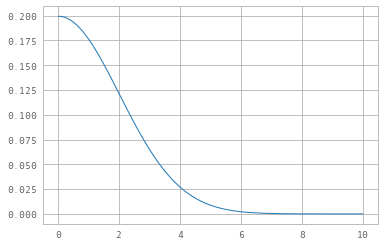

In [3]:
plt.plot(z_t, y);

Inverse CDF:

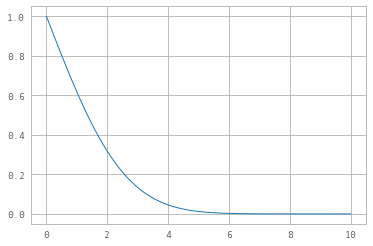

In [20]:
dist = stats.norm(0, sigma_z)
z_t = np.linspace(0, 10, 100)
y = 2*(1 - dist.cdf(z_t))
plt.plot(z_t, y)

In Meert (2018), we use a normalized zero-mean Gaussian:

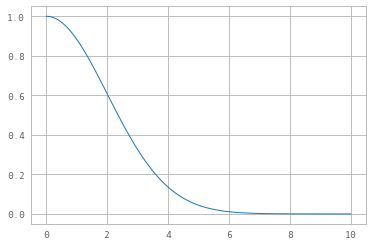

In [4]:
y = np.exp(-0.5 * (np.abs(z_t - x_t) / sigma_z)**2)
plt.plot(z_t, y);

This is a more natural interpretation. If the measurement matches the location state there is a 100% change this can be generated by this location state. See also Lauren's derivation with a CDF.

## Transition Probability

\begin{align}
p(d_t) = \frac{1}{\beta} e^{\frac{-d_t}{\beta}}
\end{align}

At $d_t=0.0$, $p(d_t)=6$, thus $\beta=\frac{1}{6}$

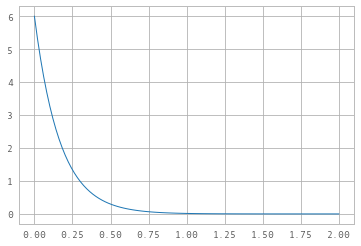

In [2]:
beta = 1/6
x = np.linspace(0, 2, 100)
y = 1 / beta * np.exp(-x / beta)
plt.plot(x, y);

This we can transform a probability by using the inverse CDF:
\begin{align}
P(d_t) = p(d > d_t) = e^{\frac{-d_t}{\beta}}
\end{align}

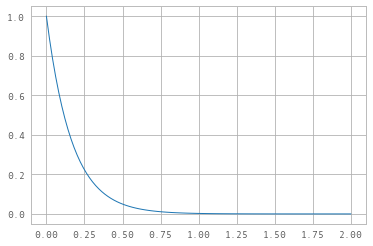

In [3]:
beta = 1/6
x = np.linspace(0, 2, 100)
y = np.exp(-x / beta)
plt.plot(x, y);

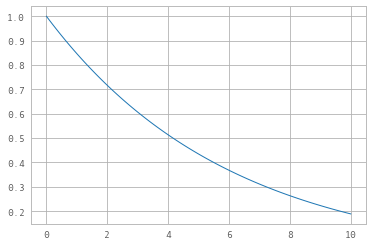

In [14]:
beta = 6
x = np.linspace(0, 10, 100)
y = np.exp(-x / beta)
plt.plot(x, y);

But a logistic-like function would be better. The intuition is that distances smaller than a certain threshold are all ok.

5.095930801728114


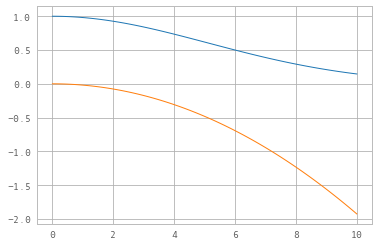

In [15]:
x_half = 6
beta = np.sqrt(np.power(x_half, 2) / (np.log(2)*2))
print(beta)
x = np.linspace(0, 10, 100)
y = np.exp(-np.power(x, 2) / (2 * beta**2))
# y = np.exp(-x / beta)
plt.plot(x, y);
ly = np.log(y)
plt.plot(x, ly)